In [71]:

import os
import pandas as pd
import numpy as np
import sys
from collections import defaultdict
import scipy.stats as st
import json


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.colors as clr
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import collections  as mc
import matplotlib.colors as clr
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

sys.path.append("scripts/")
import scripts.conf as conf
import scripts.oncotree
conf.config_params()
oncotree = scripts.oncotree.Oncotree()

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

In [73]:
if not(os.path.exists("source_data/model_information_including_generals.tsv.gz")):
    !python scripts/prepare_table_VUS_annotations.py

Number of unique mutatoins... 55729
cases that invoke general models: 72
general models invoked: 48
Number of mutations 55729
sys:1: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
scripts/prepare_table_VUS_annotations.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oncokb["oncokb"] = True


# Extended Figure 9, panel b

### First, load the source data.

In [74]:
df_observed = pd.read_csv("source_data/unique_observed_mutations_model_specificity_clinvar_oncokb.tsv.gz",sep="\t")


### Prepare the data

In [75]:
 def count_unique(grp):
    return len(set(grp)) 
x=df_observed[["CANCER_TYPE","gene","type_model"]].drop_duplicates().groupby(["CANCER_TYPE","type_model"]).agg({"gene":count_unique}).reset_index().set_index(["CANCER_TYPE"])
x=x.pivot_table(index=["CANCER_TYPE"],values=["gene"],columns=["type_model"]).fillna(0.0)
x["total"]=x.sum(axis=1)
x.columns=["gene other ttype","gene specific","gene/ttype specific","no-model","total"]
x["total_models"] = x["gene other ttype"] + x["gene specific"] + x["gene/ttype specific"]
x["represent"] = x.apply(lambda row: row.name in conf.selecte_ttypes,axis=1)

### Prepare a plot 

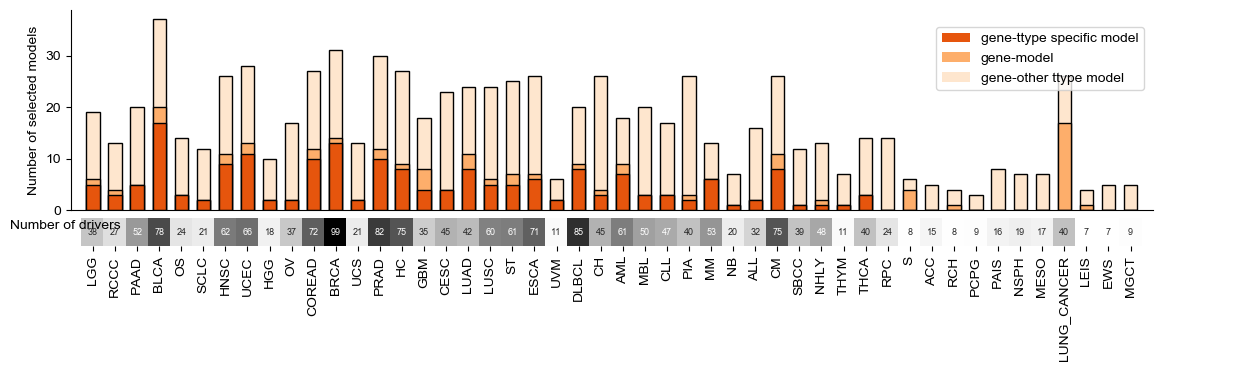

In [76]:
fig, ax = plt.subplots(figsize=(15, 4))

gs = gridspec.GridSpec(figure=fig, ncols=2, nrows=4, height_ratios=[7, 1, 1,1],width_ratios=[15,1])
gs.update(hspace=0.1, wspace=0.015)
ax0 = plt.subplot(gs[0]) # density top
ax0b = plt.subplot(gs[1]) # density top
ax1 = plt.subplot(gs[2]) # null
ax1b = plt.subplot(gs[3]) # density top
ax2 = plt.subplot(gs[4]) # null
ax2b = plt.subplot(gs[5]) # density top
ax3 = plt.subplot(gs[6]) # null
ax3b = plt.subplot(gs[7]) # density top
ttypes,xs,ys,xticks = [], [], [], []
j=0
b=x[x["represent"]].sort_values("total_models",ascending=False)
ttypes = conf.selecte_ttypes
for ttype in ttypes:
    r=b.loc[ttype]
    #ax0.bar(x=j,height=r["gene other ttype"]+r["gene specific"]+r["gene/ttype specific"]+r["no-model"],color="white",width=0.6,edgecolor="black")
    ax0.bar(x=j,height=r["gene other ttype"]+r["gene specific"]+r["gene/ttype specific"],color="#fee6ce",width=0.6,edgecolor="black")
    ax0.bar(x=j,height=r["gene specific"]+r["gene/ttype specific"],color="#fdae6b",width=0.6,edgecolor="black")
    ax0.bar(x=j,height=r["gene/ttype specific"],color="#e6550d",width=0.6,edgecolor="black")
    

    xticks.append(j)
    j+=1

# total models
l=[]
for ttype in ttypes:    
    l.append(b.loc[ttype]["total"])
df_1=pd.DataFrame(l).T
df_1.columns=ttypes
sns.heatmap(df_1,cmap="Greys",annot=True, fmt="g",ax=ax1,cbar=False, annot_kws={"fontsize":6.5})


ax1.set_xlim(ax1.get_xlim()[0]-.5,ax1.get_xlim()[1]+.5)
ax1.set_ylim(ax1.get_ylim()[0]-.25,ax1.get_ylim()[1]+.25)
ax1.set_ylabel("Number of drivers",rotation=0)
ax1.set_yticks([])


ax0.set_xticks([])
ax1.set_xticks([x + 0.5 for x in list(range(0,len(ttypes)))]
                )
_=ax1.set_xticklabels(conf.selecte_ttypes,rotation=90)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.set_xlim(-1,len(ttypes))
ax0.set_ylabel(f"Number of selected models")
for ax in [ax3,ax2,ax0b,ax1b,ax2b,ax3b]:
    ax.axis("off")
ax0.legend([mpatches.Patch(facecolor="#e6550d",alpha=1.),mpatches.Patch(facecolor="#fdae6b",alpha=1.),mpatches.Patch(facecolor="#fee6ce",alpha=1.)],["gene-ttype specific model","gene-model","gene-other ttype model"], numpoints=1,loc =(0.8,0.6))
plt.savefig(f'./raw_plots/ttype_models_boostdm_all.pdf', dpi=800,bbox_inches="tight")
plt.show()

### Pan-cancer

In [77]:
def count_unique(grp):
    return len(set(grp)) 
x=df_observed[["CANCER_TYPE","gene","type_model"]].drop_duplicates().groupby(["type_model"]).agg({"gene":"count"}).reset_index().set_index(["type_model"]).T


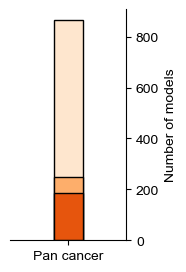

In [78]:
fig, ax = plt.subplots(figsize=(1.5, 3))
ttype_selected = x["gene/ttype specific"]
other_ttype_selected = x["gene other ttype"]
gene_selected = x["gene specific"]
no_model = x["no-model"]

#x.bar(x=0,height=gene_selected+ttype_selected+other_ttype_selected+no_model,width=0.2,color="white",edgecolor="black")
ax.bar(x=0,height=gene_selected+ttype_selected+other_ttype_selected,width=0.2,color="#fee6ce",edgecolor="black")
ax.bar(x=0,height=gene_selected+ttype_selected,width=0.2,color="#fdae6b",edgecolor="black")
ax.bar(x=0,height=ttype_selected,width=0.2,color="#e6550d",edgecolor="black")

ax.set_xlim(-0.4,.4)
ax.set_xticks([0])
ax.set_xticklabels(["Pan cancer"])
ax.set_ylabel(f"Number of models")
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.savefig(f'./raw_plots/models_boostdm_all.pdf', dpi=800,bbox_inches="tight")
#ax.legend([mpatches.Patch(facecolor="#e6550d",alpha=1.),mpatches.Patch(facecolor="#fdae6b",alpha=1.),mpatches.Patch(facecolor="#fee6ce",alpha=1.)],["gene-ttype specific model","gene-model","gene-other ttype model"], numpoints=1,loc =(0.8,0.6))
plt.show()

# Extended Figure 9 c

### First load the data

In [79]:
def ratio(grp):
    return np.nansum(grp) / len(grp)

In [80]:
df_observed = pd.read_csv("source_data/unique_observed_mutations_model_specificity_clinvar_oncokb.tsv.gz",sep="\t")
df_cohorts = pd.read_csv(conf.cohorts_path,sep="\t")
a=df_observed.groupby(["CANCER_TYPE"]).agg({"model_gene_ttype_specific":ratio,"model_gene_other_ttype":ratio,"selected_nottype_specific":ratio})
d_samples=df_cohorts.groupby(["CANCER_TYPE"]).agg({"SAMPLES":np.sum}).to_dict()["SAMPLES"]
d_mutations=df_cohorts.groupby(["CANCER_TYPE"]).agg({"MUTATIONS":np.sum}).to_dict()["MUTATIONS"]
d_unique_mutations=df_observed.groupby(["CANCER_TYPE"]).agg({"gene":"count"}).to_dict()["gene"]
d_samples["LUNG_CANCER"] = d_samples["NSCLC"]
d_samples["NSCLC"] = 0
a["represent"] = a.apply(lambda row: d_samples[row.name]>50 and d_unique_mutations[row.name]>30,axis=1)



In [81]:
ratio_clinvar = df_observed[df_observed["clinvar"]==True].shape[0] / df_observed.shape[0]
ratio_oncokb = df_observed[df_observed["oncokb"]==True].shape[0] / df_observed.shape[0]

ratio_other_ttype_selected = df_observed[df_observed["model_gene_other_ttype"]].shape[0] / df_observed.shape[0]
ratio_gene_selected = df_observed[df_observed["selected_nottype_specific"]].shape[0] / df_observed.shape[0]
ratio_ttype_selected = df_observed[df_observed["model_gene_ttype_specific"]].shape[0] / df_observed.shape[0]

### Pan-cancer

In [82]:
def plot_right_bar(ax0,ax1,ax2,ax3):
    ttypes,xs,ys,xticks = [], [], [], []
    j=0
    b=a[a["represent"]].sort_values("model_gene_ttype_specific",ascending=False)

    ax0.bar(x=0,height=ratio_other_ttype_selected,width=0.2,color="#fee6ce",edgecolor="black")
    ax0.bar(x=0,height=ratio_gene_selected,bottom=ratio_ttype_selected,width=0.2,color="#fdae6b",edgecolor="black")
    ax0.bar(x=0,height=ratio_ttype_selected,width=0.2,color="#e6550d",edgecolor="black")
    ax0.bar(x=0.5,height=ratio_clinvar,width=0.2,color="#66c2a5",edgecolor="black")
    ax0.bar(x=1.0,height=ratio_oncokb,width=0.2,color="#8da0cb",edgecolor="black")




    # variants classified
    l=[df_observed[df_observed["model_gene_other_ttype"]].shape[0],df_observed[df_observed["clinvar"]==True].shape[0],df_observed[df_observed["oncokb"]==True].shape[0]]
    df_1=pd.DataFrame(l).T
    sns.heatmap(df_1,cmap="Greys",annot=True, fmt="d",ax=ax1,cbar=False,vmin=0)




    # variants total
    l=[df_observed.shape[0]]
    df_1=pd.DataFrame(l).T
    sns.heatmap(df_1,cmap="Greys",annot=True, fmt="d",ax=ax2,cbar=False,vmin=0)


    # samples
    l=[sum(d_samples.values())]
    df_1=pd.DataFrame(l).T
    sns.heatmap(df_1,cmap="Greys",annot=True, fmt="d",ax=ax3,cbar=False,vmin=0)




    _=ax0.set_xticks(xticks)
    ax0.set_xticklabels([])
    #ax0.set_xlim(-.6,1.6)
    ax0.set_ylim(-0.01,ax.get_ylim()[1])

    _=ax1.set_xticks([])

    ax1.set_ylabel("",rotation=0)
    ax1.set_yticks([])


    _=ax2.set_xticks([])

    ax2.set_ylabel("",rotation=0)
    ax2.set_yticks([])


    ax3.set_ylabel("",rotation=0)
    ax3.set_yticks([])
    ax3.set_xticks([])

    _=ax3.set_xticklabels([],rotation=90)
    ax0.spines['left'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.legend([mpatches.Patch(facecolor="#e6550d",alpha=1.),mpatches.Patch(facecolor="#fdae6b",alpha=1.),mpatches.Patch(facecolor="#fee6ce",alpha=1.),mpatches.Patch(facecolor="#66c2a5",alpha=1.),mpatches.Patch(facecolor="#8da0cb",alpha=1.)],["gene-ttype specific model","gene-model","gene-other ttype model", "clinvar annotated","oncokb annotated"], numpoints=1,loc =(0.8,0.6))
    ax0.yaxis.set_label_position("right")
    ax0.yaxis.tick_right()
    ax0.set_ylabel(f"Proportion of observed classified \n variants  ")
    ax3.set_xticks([0.5])
    ax3.set_xticklabels(["PAN-CANCER"],rotation=90)
    #plt.savefig(f'./plots/pancancer_VUS_boostdm.pdf', dpi=800,bbox_inches="tight")


### Plot it!

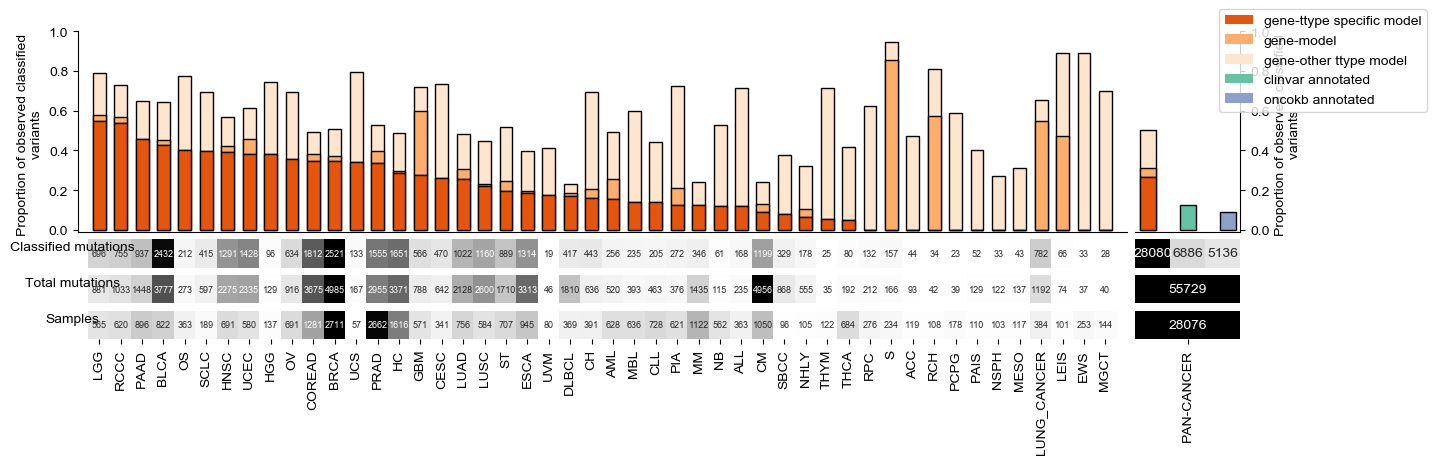

In [83]:
fig, ax = plt.subplots(figsize=(15, 4))

gs = gridspec.GridSpec(figure=fig, ncols=2, nrows=4, height_ratios=[7, 1, 1,1],width_ratios=[15,1.5])
gs.update(hspace=0.1, wspace=0.015)
ax0 = plt.subplot(gs[0]) # density top
ax0b = plt.subplot(gs[1]) # density top
ax1 = plt.subplot(gs[2]) # null
ax1b = plt.subplot(gs[3]) # density top
ax2 = plt.subplot(gs[4]) # null
ax2b = plt.subplot(gs[5]) # density top
ax3 = plt.subplot(gs[6]) # null
ax3b = plt.subplot(gs[7]) # density top
ttypes,xs,ys,xticks = [], [], [], []
j=0
b=a[a["represent"]].sort_values("model_gene_ttype_specific",ascending=False)
for i,r in b.iterrows():
    ax0.bar(x=j,height=r["model_gene_other_ttype"],color="#fee6ce",width=0.6,edgecolor="black")
    ax0.bar(x=j,height=r["selected_nottype_specific"],bottom=r["model_gene_ttype_specific"],color="#fdae6b",width=0.6,edgecolor="black")
    ax0.bar(x=j,height=r["model_gene_ttype_specific"],color="#e6550d",width=0.6,edgecolor="black")
    
    
    ttypes.append(i)
    xticks.append(j)
    j+=1
# variants classified
l=[]
for ttype in ttypes:    
    l.append(df_observed[(df_observed["CANCER_TYPE"]==ttype)&(df_observed["model_gene_other_ttype"])].shape[0])
df_1=pd.DataFrame(l).T
df_1.columns=ttypes
sns.heatmap(df_1,cmap="Greys",annot=True, fmt="d",ax=ax1,cbar=False, annot_kws={"fontsize":6.5})
# variants total
l=[]
for ttype in ttypes:    
    l.append(df_observed[df_observed["CANCER_TYPE"]==ttype].shape[0])
df_1=pd.DataFrame(l).T
df_1.columns=ttypes
sns.heatmap(df_1,cmap="Greys",annot=True, fmt="d",ax=ax2,cbar=False, annot_kws={"fontsize":6.5})

# total samples
l=[]
for ttype in ttypes:    
    l.append(d_samples[ttype])
df_1=pd.DataFrame(l).T
df_1.columns=ttypes
sns.heatmap(df_1,cmap="Greys",annot=True, fmt="d",ax=ax3,cbar=False, annot_kws={"fontsize":6.5})


_=ax0.set_xticks(xticks)
ax0.set_xticklabels([])
ax0.set_xlim(-1,j)
ax0.set_ylim(-0.01,ax.get_ylim()[1])

_=ax1.set_xticks([])
ax1.set_xlim(ax1.get_xlim()[0]-.5,ax1.get_xlim()[1]+.5)
ax1.set_ylim(ax1.get_ylim()[0]-.25,ax1.get_ylim()[1]+.25)
ax1.set_ylabel("Classified mutations",rotation=0)
ax1.set_yticks([])


_=ax2.set_xticks([])
ax2.set_xlim(ax1.get_xlim()[0],ax1.get_xlim()[1])
ax2.set_ylim(ax1.get_ylim()[0],ax1.get_ylim()[1])
ax2.set_ylabel("Total mutations",rotation=0)
ax2.set_yticks([])


ax3.set_xlim(ax1.get_xlim()[0],ax1.get_xlim()[1])
ax3.set_ylim(ax1.get_ylim()[0],ax1.get_ylim()[1])
ax3.set_ylabel("Samples",rotation=0)
ax3.set_yticks([])


ax0.set_xticks([])

_=ax3.set_xticklabels(ttypes,rotation=90)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

plot_right_bar(ax0b,ax1b,ax2b,ax3b)
    
ax0.set_ylabel(f"Proportion of observed classified \n variants  ")

#plt.savefig(f'./plots/ttype_VUS_boostdm_all.pdf', dpi=800,bbox_inches="tight")
plt.show()

# Extended Figure 9d

### Generate source data

In [84]:
if not(os.path.exists("source_data/driver_per_sample_boostdm.tsv")):
    !python scripts/compute_number_of_drivers_per_sample.py

100%|█████████████████████████████████████████| 864/864 [07:44<00:00,  1.86it/s]


### Load data

In [85]:
df_boostdm = pd.read_csv("source_data/driver_per_sample_boostdm.tsv",sep="\t")
with open(conf.dictionary_dndscv,'r') as f:
    d_excess_muts=json.load(f)
df_cohorts = pd.read_csv(conf.cohorts_path,sep="\t")

### Functions plotting

In [86]:
def p75(grp):
    return np.nanpercentile(grp,[90])
def p25(grp):
    return np.nanpercentile(grp,[10])

def compute_drivers_dndcv(order):
    values_excess = []
    ci_ls,ci_lst = [], []
    ci_us,ci_ust = [], []
    values_total = []
    for ttype in order:
        cohorts = list(df_cohorts[df_cohorts["CANCER_TYPE"]==ttype]["COHORT"].values)
        values_cohort_dndscv, values_cohort_total = [],[]
        for cohort in cohorts:
            if not(cohort in d_excess_muts):
                continue
            values_cohort_dndscv+=list(d_excess_muts[cohort])
        mean_excess = np.nanmean(values_cohort_dndscv)
        values_excess.append(mean_excess)
        ci_ls.append(p25(values_cohort_dndscv))
        ci_us.append(p75(values_cohort_dndscv))
    return values_excess,ci_ls,ci_us

### Plot it, per tumor type

In [87]:
parsed_dataset=df_boostdm.groupby("CANCER_TYPE").agg(mean_driver_mutations=("boostDM_class",np.nanmean),ci_l=("boostDM_class",p25),ci_u=("boostDM_class",p75)).reset_index()
order = parsed_dataset.sort_values("CANCER_TYPE",ascending=True)["CANCER_TYPE"].values
parsed_dataset.sort_values("CANCER_TYPE",ascending=True,inplace=True)
values_excess,ci_ls,ci_us=compute_drivers_dndcv(order)

### 

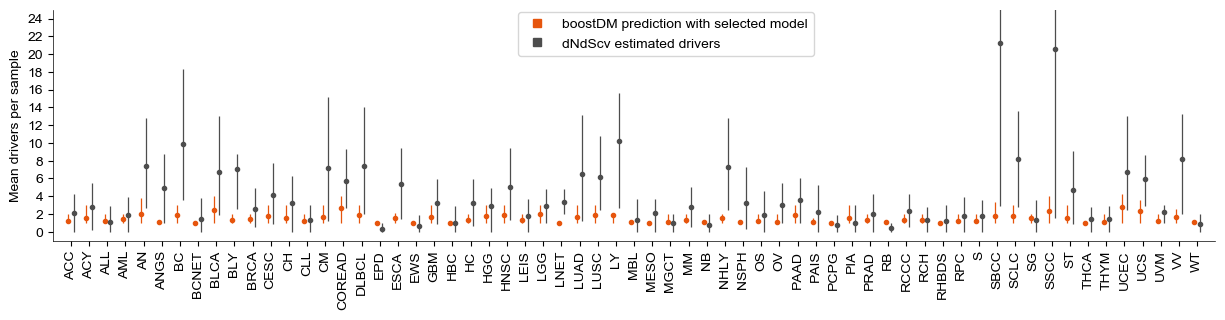

In [88]:
# boostdm
values_total = parsed_dataset.mean_driver_mutations.values
ci_l = parsed_dataset.ci_l.values
ci_u = parsed_dataset.ci_u.values
y_error = [[values_total[i] - ci_l[i], ci_u[i] - values_total[i]] for i in range(len(values_total))]


# dndscv

y_error_dndscv = [[float(values_excess[i] - ci_ls[i]), float(ci_us[i] - values_excess[i])] for i in range(len(values_excess))]



fig,ax = plt.subplots(figsize=(15,3))
xs = range(0,len(order))
ax.errorbar([x-0.15 for x in xs], values_total, yerr=np.array(y_error).T, ecolor='#e6550d', capthick=2,fmt='o',elinewidth=0.9,markersize=3,c="#e6550d" )
ax.errorbar([x+0.15 for x in xs], values_excess, yerr=np.array(y_error_dndscv).T, ecolor='#4d4d4d', capthick=2,fmt='o',elinewidth=0.9,markersize=3,c="#4d4d4d" )
#ax.scatter(x=xs,y=values,s=5)
ax.set_xticks(xs)
_=ax.set_xticklabels(order,fontsize=10,rotation=90)
ax.set_yticks(np.arange(0,25,2))
ax.set_yticklabels(["{:.0f}".format(x) for x in np.arange(0,25,2)])
ax.set_ylabel("Mean drivers per sample")
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
#ax.tick_params(axis = 'x', labelsize =4  , pad=0.02 ,width=0.0)
ax.set_xlim(-1,len(xs))
ax.set_ylim(-1,25)

markers = [plt.Line2D([0,0],[0,0],color="#e6550d", marker='s', linestyle=''),
           plt.Line2D([1,0],[0,0],color="#4d4d4d", marker='s', linestyle=''),
          ]
ax.legend(markers, ["boostDM prediction with selected model","dNdScv estimated drivers"], 
           numpoints=1,loc =(0.4,0.8),facecolor=None )

plt.savefig("raw_plots/n_drivers_per_ttype_boostDM_no_hypermutated.pdf",bbox_inches="tight",dpi=100)
plt.show()

### General, plot (right panel)

In [89]:
df_boostdm["intogen"] =True
parsed_dataset=df_boostdm.groupby("intogen").agg(mean_driver_mutations=("boostDM_class",np.nanmean),ci_l=("boostDM_class",p25),ci_u=("boostDM_class",p75)).reset_index()
order = parsed_dataset.sort_values("mean_driver_mutations",ascending=False)["intogen"].values
parsed_dataset.sort_values("mean_driver_mutations",ascending=False,inplace=True)

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


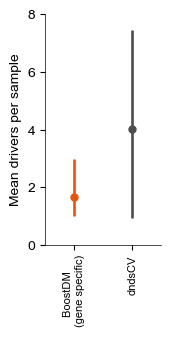

In [90]:
values_total = parsed_dataset.mean_driver_mutations.values

ci_l = parsed_dataset.ci_l.values
ci_u = parsed_dataset.ci_u.values
y_error = [[values_total[i] - ci_l[i], ci_u[i] - values_total[i]] for i in range(len(values_total))]

fig,ax = plt.subplots(figsize=(1.5,3))
xs = range(0,len(order))
ax.errorbar(-0.5, values_total, yerr=np.array(y_error).T, ecolor='#e6550d', capthick=2,fmt='o',elinewidth=1.9,markersize=5,c="#e6550d" )
y_error_dn = [[np.nanmean(values_excess) - p25(values_excess)],[p75(values_excess) - np.nanmean(values_excess)]]
ax.errorbar(0.5,[np.nanmean(values_excess)], yerr=np.array(y_error_dn), ecolor='#4d4d4d', capthick=2,fmt='o',elinewidth=1.9,markersize=5,c="#4d4d4d" )
#ax.scatter(x=xs,y=values,s=5)
ax.set_xticks([-.5,.5])
_=ax.set_xticklabels(["BoostDM \n (gene specific)","dndsCV"],fontsize=8,rotation=90)
ax.set_yticks(np.arange(0,10,2))
ax.set_yticklabels(["{:.0f}".format(x) for x in np.arange(0,10,2)])
ax.set_ylabel("Mean drivers per sample")
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
#ax.tick_params(axis = 'x', labelsize =4  , pad=0.02 ,width=0.0)
ax.set_xlim(-1,len(xs))
#ax.set_ylim(-1,22)
plt.savefig("raw_plots/n_drivers_total_boostDM_no_hypermutated.pdf",bbox_inches="tight",dpi=100)
plt.show()